# TECH VENDOR PROFILER

---
#Preparation

## Installing packages

In [1]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 911kB 4.5MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.

## Importing libraries and modules

In [2]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import json
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
import pprint
import re
import warnings
import math
warnings.filterwarnings("ignore")

In [5]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

## Global functions

In [24]:
#Function to generate a report with the percentage of missing values for each field that has one missing value at least

def print_missing_valuePerc(ds):
    field_list = [] 
    field_list = ds.columns[ds.isnull().any()].tolist()
    for r in field_list:
        print(round(ds[r].isnull().sum()/ds.shape[0],6)*100, "% of records has missing value in the field",r)
        
#Function to describe all statistics feature of the dataset

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)  
 #Function that takes and show a screenshot of the webpage where the ghost driver is on 

def webpage_shot():
    wd.save_screenshot('screenshot.png')
    %pylab inline
    img=mpimg.imread('/content/screenshot.png')
    imgplot = plt.imshow(img)
    print(wd.title)
    return plt.show()

## Set global constants

In [6]:
vendor1 = "MediaWorld"
vendor2 = "Unieuro" 
linkMediaWorld = "https://www.mediaworld.it/catalogo/telefonia/smartphone-e-cellulari/smartphone"
linkUnieuro = "https://www.unieuro.it/online/Telefonia-e-Smartphone/Smartphone-e-Cellulari/Smartphone"
scrWidth = 1920
scrHeight = 1080
delay = 10

---
# Extraction - MediaWorld scraping

In [7]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.set_window_size(scrWidth, scrHeight)
wd.get(linkMediaWorld)
time.sleep(delay)
list_mediaworld_smartphone = wd.find_elements_by_css_selector("div.main-content.is-catalog-page > div.search-product-list.js-comp.active > div.search-product-list-content.display-mode-list.active > article")
print(len(list_mediaworld_smartphone))

24


24 products per page

Populating the interactive namespace from numpy and matplotlib
Migliori Smartphone Offerte e Prezzi | Mediaworld.it


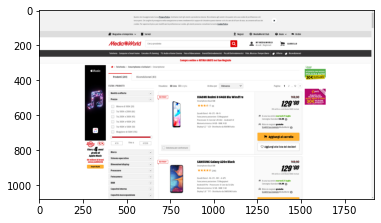

In [ ]:
webpage_shot()

Function that retrieves all the products link of the products along the pages. 
I set original price equal to the current price if the product is not discounted

In [8]:
def get_product_info_MediaWorld(s,tms):
  url = ""
  product_name = ""
  product_category = ""
  original_price = ""
  price = ""

  try:
      url = s.find_elements_by_css_selector("div.col-2 h3.product-name a")[0].get_attribute("href")
      product_name = s.find_elements_by_css_selector("div.col-2 h3.product-name a")[0].text
      product_category = s.find_elements_by_css_selector("div.col-2 p.product-category")[0].text
      if (len(s.find_elements_by_css_selector("div.col-3 span.full-price.mw-price.strikeout.enhanced")) == 1):
             original_price = s.find_elements_by_css_selector("div.col-3 span.full-price.mw-price.strikeout.enhanced")[0].text.replace(',','.')
      else:
             original_price = price = s.find_elements_by_css_selector("div.price-container span")[0].text.replace(',','.')        
      price = s.find_elements_by_css_selector("div.price-container span")[0].text.replace(',','.')   
  except:
    pass
  return {'tms_loading': tms_loading,
          'vendor': vendor1,
          'url': url,
          'product_name': product_name,
          'product_category': product_category,
          'original_price': original_price,
          'price': price}

Find the total number of pages to scrape

In [9]:
count_products = wd.find_elements_by_css_selector("li.active")[0].text
total_count_products = re.sub('(\)|\(|Prodotti )','',count_products)
products_per_page = wd.find_elements_by_css_selector("span.pagination.top > span.pages")[0].get_attribute("data-pagination-count")
total_pages_mediaworld = math.ceil(int(total_count_products)/int(products_per_page))
print(total_pages_mediaworld)

13


Collecting all the links related to every singles product. The link will be used to access to its proper page and get additional data

In [10]:
all_mediaworld_phones = []

tms_loading = dt.datetime.now()

for num in tqdm(range(1,total_pages_mediaworld + 1)):
  wd.get(f"https://www.mediaworld.it/catalogo/telefonia/smartphone-e-cellulari/smartphone?pageNumber={num}")
  time.sleep(20)
  list_mediaworld_smartphone = wd.find_elements_by_css_selector("div.main-content.is-catalog-page > div.search-product-list.js-comp.active > div.search-product-list-content.display-mode-list.active > article")
  for s in list_mediaworld_smartphone:
    all_mediaworld_phones.append(get_product_info_MediaWorld(s,tms_loading))

print('Total collected products: ' + str(len(all_mediaworld_phones)) + '/' + str(total_count_products))


Total collected products: 290/293


Setting a dataframe to collect the products which have just been scraped

In [11]:
ds_all_mediaworld_phones = pd.DataFrame(all_mediaworld_phones)
ds_all_mediaworld_phones.tail()

,tms_loading,vendor,url,product_name,product_category,original_price,price
285,2020-07-23 11:47:47.640936,MediaWorld,https://www.mediaworld.it/product/p-101903/alc...,ALCATEL 1S BLUE,Smartphone Dual SIM,95.99,84.99
286,2020-07-23 11:47:47.640936,MediaWorld,https://www.mediaworld.it/product/p-112082/app...,APPLE iPhone 11 64GB (PRODUCT)RED,Smartphone,839.00,769.00
287,2020-07-23 11:47:47.640936,MediaWorld,https://www.mediaworld.it/product/p-126171/hua...,HUAWEI P smart Pro Crystal,Smartphone Dual SIM,299.99,261.99
288,2020-07-23 11:47:47.640936,MediaWorld,https://www.mediaworld.it/product/p-131699/sam...,SAMSUNG Galaxy A31 Black,Smartphone Dual SIM,299.99,269.99
289,2020-07-23 11:47:47.640936,MediaWorld,https://www.mediaworld.it/product/p-131703/sam...,SAMSUNG Galaxy A31 Blue,Smartphone Dual SIM,299.99,299.99


In [12]:
ds_all_mediaworld_phones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tms_loading       290 non-null    datetime64[ns]
 1   vendor            290 non-null    object        
 2   url               290 non-null    object        
 3   product_name      290 non-null    object        
 4   product_category  290 non-null    object        
 5   original_price    290 non-null    object        
 6   price             290 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 16.0+ KB


In [13]:
ds_all_mediaworld_phones.duplicated().sum()

14

It seems that MediaWorld replicates the last product of a page to the beginning of the next page. The products are the same then i drop them from the dataset

In [14]:
ds_all_mediaworld_phones = ds_all_mediaworld_phones.drop_duplicates()

This function get all the specs for every product pass as parameters

In [15]:
def get_prod_spec_MediaWorld(prod,tms,date_loading,price,original_price,brand):
  os = ""
  ram = ""
  memory = ""
  brand
  model = ""
  sim = ""
  color = ""
  display_type = ""
  display_size = ""
  carrier = ""
  battery_capacity = ""
  weight = ""
  gps = ""
  a_gps = ""
  dimension = ""
  height = ""
  width = ""
  length = ""

  check = True
  i = 0


  for c in prod:
      try:
        while True:
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Sistema operativo:"):
           os = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip() 
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "RAM:"):
           ram = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip() 
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Modello:"):
           model = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()  
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Capacità interna:"):
           memory = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip() 
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Numero Sim:"):
           sim = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()     
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Colore:"):
           color = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip() 
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Tipologia schermo:"):
           display_type = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()  
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Dimensioni display ('):"):
           display_size = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()  
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Capacità batteria:"):
           battery_capacity = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()    
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Operatore:"):
           carrier = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()    
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Peso (kg):"):
           weight = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()     
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "GPS:"):
           gps = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()  
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "A-GPS:"):
           a_gps = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()  
          if(c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__key")[i].get_attribute("textContent").strip() == "Dimensioni:"):
           dimension = c.find_elements_by_css_selector(".Tech-row__inner.Tech-row__inner__value")[i].get_attribute("textContent").strip()  
           width = dimension.split('x')[0]
           height = dimension.split('x')[1]
           length = dimension.split('x')[2]

          i += 1
      except:
        check = False
        pass
  return {'tms_loading': tms,
          'date_loading': date_loading,
          'vendor': vendor1, 
          'os': os,
          'brand': brand,
          'model': model,
          'price': price,
          'original_price': original_price,
          'ram': ram,
          'memory': memory,
          'sim': sim,
          'gps': gps,
          'a_gps': a_gps,
          'color': color,
          'display_type': display_type,
          'display_size': display_size,
          'carrier': carrier,
          'battery_capacity': battery_capacity,
          'height':height,
          'width':width,
          'length':length,
          'weight': weight} 

Appending all specs retrieved in a list. To ensure a correct loading of the page we use the class WebDriverWait

In [16]:
all_mediaworld_spec_phones = []

tms_loading = dt.datetime.now()

date_loading = dt.date.today()

for index, project in tqdm(ds_all_mediaworld_phones.iterrows()):
    time.sleep(np.random.randint(1,delay))
    link = project["url"]
    price = project["price"]
    original_price = project["original_price"]
    brand = project["product_name"].split(' ')[0]
    try:
      wd.set_window_size(scrWidth, scrHeight)
      wd.get(link)
      try:
       WebDriverWait(wd, 10).until(
          EC.element_to_be_clickable((By.CLASS_NAME, "product-add-to-cart mw-yellow-btn btn-size-md js-add-to-cart"))
       )
      except:
        pass
      prod = wd.find_elements_by_class_name("product-content-wrapper")
      all_mediaworld_spec_phones.append(get_prod_spec_MediaWorld(prod,tms_loading,date_loading,price,original_price,brand))
    except Exception as e:
      print(e) 

Put the list into a PANDAS Dataframe

In [17]:
ds_spec_phones_mediaworld = pd.DataFrame(all_mediaworld_spec_phones)
ds_spec_phones_mediaworld.head()

,tms_loading,date_loading,vendor,os,brand,model,price,original_price,ram,memory,sim,gps,a_gps,color,display_type,display_size,carrier,battery_capacity,height,width,length,weight
0,2020-07-23 11:54:52.121813,2020-07-23,MediaWorld,Android,SAMSUNG,Galaxy A20e,129.99,179.99,3 GB,32 GB,Dual SIM,Sì,Sì,Black,LCD,"5,8",N.d,3000 mAh,"14,74","6,97","0,84 cm","0,14"
1,2020-07-23 11:54:52.121813,2020-07-23,MediaWorld,Android,SAMSUNG,Galaxy A71,359.00,459.00,6 GB,128 GB,Dual SIM,Sì,Sì,Black,Super AMOLED,"6,7",No,4500 mAh,"16,36","7,6","0,77 cm","0,179"
2,2020-07-23 11:54:52.121813,2020-07-23,MediaWorld,Android,SAMSUNG,Galaxy S20 4G,699.00,929.00,8 GB,128 GB,Mono SIM,Sì,Sì,Grey,Dynamic AMOLED,"6,2",No,4000 mAh,"15,17","6,91","0,79 cm","0,163"
3,2020-07-23 11:54:52.121813,2020-07-23,MediaWorld,Android,SAMSUNG,Galaxy A51,279.00,359.00,4 GB,128 GB,Dual SIM,Sì,Sì,Black,Super AMOLED,"6,5",No,4000 mAh,"15,85","7,36","0,79 cm","0,172"
4,2020-07-23 11:54:52.121813,2020-07-23,MediaWorld,Android,SAMSUNG,Galaxy A71,359.00,459.00,6 GB,128 GB,Dual SIM,Sì,Sì,Silver,Super AMOLED,"6,7",No,4500 mAh,"16,36","7,6","0,77 cm","0,179"


In [18]:
ds_spec_phones_mediaworld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tms_loading       276 non-null    datetime64[ns]
 1   date_loading      276 non-null    object        
 2   vendor            276 non-null    object        
 3   os                276 non-null    object        
 4   brand             276 non-null    object        
 5   model             276 non-null    object        
 6   price             276 non-null    object        
 7   original_price    276 non-null    object        
 8   ram               276 non-null    object        
 9   memory            276 non-null    object        
 10  sim               276 non-null    object        
 11  gps               276 non-null    object        
 12  a_gps             276 non-null    object        
 13  color             276 non-null    object        
 14  display_type      276 non-

In [19]:
ds_all_mediaworld_phones.duplicated().sum()

0

In [20]:
ds_spec_phones_mediaworld.to_csv("ds_spec_phones_mediaworld.csv",encoding="utf-8")

---
# Extraction - Unieuro scraping

In [8]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.set_window_size(scrWidth, scrHeight)
wd.get(linkUnieuro)
time.sleep(delay)
list_smartphone_unieuro = wd.find_elements_by_css_selector("div.items-container> section.hits > section.collapsed > article")
print(len(list_smartphone_unieuro))

32


Populating the interactive namespace from numpy and matplotlib
Smartphone: scopri i prezzi imbattibili di Unieuro


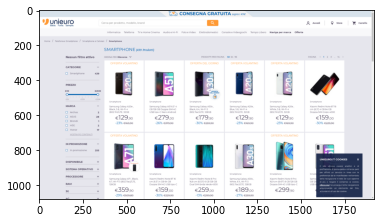

In [ ]:
webpage_shot()

Find the total number of pages to scrape

In [9]:
total_results = wd.find_elements_by_css_selector("span.total-results")[0].text
total_products_unieuro = re.sub('(\)|\(| Prodotti)','',total_results)
total_pages_unieuro = math.ceil(int(total_products_unieuro)/len(list_smartphone_unieuro))
print(total_pages_unieuro)

14


Function that retrieves all the products link of the products along the pages. 
I set original price equal to the current price if the product is not discounted

In [10]:
def get_product_info_Unieuro(s,tms):
  url = ""
  product_name = ""
  product_category = ""
  original_price = ""
  price = ""

  try:
      url = s.find_elements_by_css_selector("div.info div.product-img-container a")[0].get_attribute("href")
      product_name = s.find_elements_by_css_selector("div.info div.title a")[0].text
      product_category = s.find_elements_by_css_selector("div.info div.category")[0].text
      if(len(s.find_elements_by_css_selector("div.info span.original-price")) == 1):
            original_price = s.find_elements_by_css_selector("div.info span.original-price")[0].text.replace(',','.') 
      else:
            original_price = s.find_elements_by_css_selector("div.info div.price")[0].text.replace(',','.')         
      price = s.find_elements_by_css_selector("div.info div.price")[0].text.replace(',','.')   
  except:
    pass
  return {'tms_loading': tms,
          'vendor': vendor2,
          'url': url,
          'product_name': product_name,
          'product_category': product_category,
          'original_price': original_price,
          'price': price}

Collecting all the links related to every singles product. The link will be used to access to its proper page and get additional data

In [11]:
all_unieuro_phones = []

tms_loading = dt.datetime.now()

for num in tqdm(range(0,total_pages_unieuro)):
  wd.get(f"https://www.unieuro.it/online/Telefonia-e-Smartphone/Smartphone-e-Cellulari/Smartphone?p={num}&dFR[categories.lvl3][0]=C2101")
  time.sleep(np.random.randint(1,delay))
  list_smartphone = wd.find_elements_by_css_selector("div.items-container> section.hits > section.collapsed > article")
  for s in list_smartphone:
    all_unieuro_phones.append(get_product_info_Unieuro(s,tms_loading))

print('Total collected products: ' + str(len(all_unieuro_phones)) + '/' + total_products_unieuro)


Total collected products: 442/442


Setting a dataframe to collect the products which have just been scraped

In [12]:
ds_unieuro_phones = pd.DataFrame(all_unieuro_phones)
ds_unieuro_phones.head()

,tms_loading,vendor,url,product_name,product_category,original_price,price
0,2020-07-23 05:43:20.671189,Unieuro,https://www.unieuro.it/online/Smartphone/Galax...,"Samsung Galaxy A51 6.5"" 4 GB 128 GB Doppia SIM...",Smartphone,€379.90,€279.00
1,2020-07-23 05:43:20.671189,Unieuro,https://www.unieuro.it/online/Smartphone/Galax...,"Samsung Galaxy A30s , Black, 6.4, Wi-Fi 5 (802...",Smartphone,€259.90,€189.00
2,2020-07-23 05:43:20.671189,Unieuro,https://www.unieuro.it/online/Smartphone/Galax...,"Samsung Galaxy A30s , White, 6.4, Wi-Fi 5 (802...",Smartphone,€259.90,€189.00
3,2020-07-23 05:43:20.671189,Unieuro,https://www.unieuro.it/online/Smartphone/Note-...,"Xiaomi Redmi Note 8T 16 cm (6.3"") 4 GB 64 GB D...",Smartphone,€229.90,€169.00
4,2020-07-23 05:43:20.671189,Unieuro,https://www.unieuro.it/online/Smartphone/Galax...,"Samsung Galaxy A71 , Black, 6.7, Wi-Fi 5 (802....",Smartphone,€509.80,€359.90


In [13]:
ds_unieuro_phones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tms_loading       442 non-null    datetime64[ns]
 1   vendor            442 non-null    object        
 2   url               442 non-null    object        
 3   product_name      442 non-null    object        
 4   product_category  442 non-null    object        
 5   original_price    442 non-null    object        
 6   price             442 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 24.3+ KB


In [14]:
ds_unieuro_phones.duplicated().sum()

0

This function get all the specs for every product pass as parameters

In [15]:
def get_prod_spec_Unieuro(prod,tms,date_loading,price,original_price,brand,model,carrier):
  os = ""
  ram = ""
  memory = ""
  sim = ""
  color = ""
  display_type = ""
  display_size = ""
  battery_capacity = ""
  weight = ""
  gps = ""
  a_gps = ""
  height = ""
  width = ""
  length = ""
  
  i = 0

  check = True

  try:
    while check:
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Piattaforma"):
        os = prod.find_elements_by_css_selector("span.detail")[i].text 
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Capacità della RAM"):
        ram = prod.find_elements_by_css_selector("span.detail")[i].text 
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Capacità memoria interna"):
        memory = prod.find_elements_by_css_selector("span.detail")[i].text 
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Capacità della scheda SIM"):
        sim = prod.find_elements_by_css_selector("span.detail")[i].text     
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Colore del prodotto"):
        color = prod.find_elements_by_css_selector("span.detail")[i].text  
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Tipo di display"):
        display_type = prod.find_elements_by_css_selector("span.detail")[i].text   
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Dimensioni schermo"):
        display_size = prod.find_elements_by_css_selector("span.detail")[i].text   
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Capacità della batteria"):
       battery_capacity = prod.find_elements_by_css_selector("span.detail")[i].text    
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Peso"):
       weight = prod.find_elements_by_css_selector("span.detail")[i].text    
      if(prod.find_elements_by_css_selector("span.label")[i].text == "GPS"):
       gps = prod.find_elements_by_css_selector("span.detail")[i].text   
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Assistenza funzione GPS (A-GPS)"):
       a_gps = prod.find_elements_by_css_selector("span.detail")[i].text 
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Altezza"):
       height = prod.find_elements_by_css_selector("span.detail")[i].text   
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Larghezza"):
       width = prod.find_elements_by_css_selector("span.detail")[i].text   
      if(prod.find_elements_by_css_selector("span.label")[i].text == "Profondità"):
       length = prod.find_elements_by_css_selector("span.detail")[i].text   

      i += 1

  except:
     check = False
     pass
  return {'tms_loading': tms,
          'date_loading': date_loading,
          'vendor': vendor2, 
          'os': os,
          'brand': brand,  
          'model': model,
          'price': price,
          'original_price': original_price,       
          'ram': ram,
          'memory': memory,
          'sim': sim,
          'gps': gps,
          'a_gps': a_gps,
          'color': color,
          'display_type': display_type,
          'display_size': display_size,
          'carrier': carrier,
          'battery_capacity': battery_capacity,
          'height':height,
          'width':width,
          'length':length,
          'weight': weight} 

Appending all specs retrieved in a list. To ensure a correct loading of the page we use the class WebDriverWait

In [16]:
all_unieuro_spec_phones = []

tms_loading = dt.datetime.now()

date_loading = dt.date.today()

for index, project in tqdm(ds_unieuro_phones.iterrows()):
    time.sleep(np.random.randint(1,delay))
    link = project["url"]
    price = project["price"]
    original_price = project["original_price"]
    product_name_ext = project["product_name"]
    product_name_no_carrier = re.sub(('Vodafone|TIM|H3G|WindTre'),'',product_name_ext,flags = re.IGNORECASE)
    brand = product_name_no_carrier.split(' ')[0]
    carrier = re.match(('Vodafone|TIM|H3G|WindTre'),product_name_ext,re.IGNORECASE)
    if carrier is None:
      carrier = 'No'
    else:
      carrier = carrier.group()
    product_name_no_carrier = product_name_no_carrier.strip()  
    product_name_no_carrier_no_brand = re.sub(brand,'',product_name_no_carrier,flags = re.IGNORECASE)
    product_name_no_carrier_no_brand = product_name_no_carrier_no_brand.strip()
    model_ext = re.match('(^.*?)(,|:|[0-9] cm|[0-9] GB|[0-9]")',product_name_no_carrier_no_brand,re.IGNORECASE)
    if model_ext is None:
      model = product_name_no_carrier_no_brand
    else:
      model = re.match('.*(?=\ )',model_ext.group(),re.IGNORECASE)
      model = model.group()
    try:
      wd.set_window_size(scrWidth, scrHeight)
      wd.get(link)
      try:
       WebDriverWait(wd, 10).until(
          EC.presence_of_element_located((By.ID , "specifications"))
       )
      except:
        pass
      prod = wd.find_element_by_id("specifications")   
      all_unieuro_spec_phones.append(get_prod_spec_Unieuro(prod,tms_loading,date_loading,price,original_price,brand,model,carrier))
    except Exception as e:
      print(e) 

Put the list into a PANDAS Dataframe

In [17]:
ds_spec_phones_unieuro = pd.DataFrame(all_unieuro_spec_phones)
ds_spec_phones_unieuro.head()

,tms_loading,date_loading,vendor,os,brand,model,price,original_price,ram,memory,sim,gps,a_gps,color,display_type,display_size,carrier,battery_capacity,height,width,length,weight
0,2020-07-23 05:46:54.088812,2020-07-23,Unieuro,Android,Samsung,Galaxy A51,€279.00,€379.90,4 GB,128 GB,Doppia SIM,Sì,Sì,Nero,SAMOLED,"6.5 """,No,4000 mAh,158.5 mm,73.6 mm,7.9 mm,172 g
1,2020-07-23 05:46:54.088812,2020-07-23,Unieuro,Android,Samsung,Galaxy A30s,€189.00,€259.90,4 GB,128 GB,Doppia SIM,Sì,,Nero,SAMOLED,"6.4 """,No,4000 mAh,158.5 mm,74.7 mm,7.8 mm,169 g
2,2020-07-23 05:46:54.088812,2020-07-23,Unieuro,Android,Samsung,Galaxy A30s,€189.00,€259.90,4 GB,128 GB,Doppia SIM,Sì,Sì,Bianco,SAMOLED,"6.4 """,No,4000 mAh,158.5 mm,74.7 mm,7.8 mm,169 g
3,2020-07-23 05:46:54.088812,2020-07-23,Unieuro,Android,Xiaomi,Redmi Note 8T 16,€169.00,€229.90,4 GB,64 GB,Doppia SIM,Sì,Sì,Grigio,IPS,"6.3 """,No,4000 mAh,161.15 mm,75.4 mm,8.6 mm,199.8 g
4,2020-07-23 05:46:54.088812,2020-07-23,Unieuro,Android,Samsung,Galaxy A71,€359.90,€509.80,6 GB,128 GB,Doppia SIM,Sì,Sì,Nero,SAMOLED,"6.7 """,No,4500 mAh,163.6 mm,76 mm,7.7 mm,179 g


In [18]:
ds_spec_phones_unieuro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tms_loading       442 non-null    datetime64[ns]
 1   date_loading      442 non-null    object        
 2   vendor            442 non-null    object        
 3   os                442 non-null    object        
 4   brand             442 non-null    object        
 5   model             442 non-null    object        
 6   price             442 non-null    object        
 7   original_price    442 non-null    object        
 8   ram               442 non-null    object        
 9   memory            442 non-null    object        
 10  sim               442 non-null    object        
 11  gps               442 non-null    object        
 12  a_gps             442 non-null    object        
 13  color             442 non-null    object        
 14  display_type      442 non-

In [27]:
ds_spec_phones_unieuro = pd.read_csv("ds_spec_phones_unieuro.csv",encoding="utf-8")

Combine the resulting datasets

In [28]:
ds_all_phones_spec = ds_spec_phones_unieuro.append(ds_spec_phones_mediaworld, ignore_index = True)

NameError: ignored

In [29]:
ds_all_phones_spec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        442 non-null    float64
 1   tms_loading       718 non-null    object 
 2   date_loading      718 non-null    object 
 3   vendor            718 non-null    object 
 4   os                690 non-null    object 
 5   brand             678 non-null    object 
 6   model             718 non-null    object 
 7   price             718 non-null    object 
 8   original_price    718 non-null    object 
 9   ram               711 non-null    object 
 10  memory            715 non-null    object 
 11  sim               673 non-null    object 
 12  gps               710 non-null    object 
 13  a_gps             605 non-null    object 
 14  color             717 non-null    object 
 15  display_type      681 non-null    object 
 16  display_size      718 non-null    object 
 1

Export the resulting dataset

In [30]:
ds_all_phones_spec
ds_all_phones_spec.to_csv("ds_all_phones_spec.csv",encoding="utf-8")

---

#Transforming

1.   Data profiling with OpenRefine
2.   Data enrichment with Python



In [ ]:
df_refined = pd.read_csv (r'ds_all_phones_spec-csv_refined.csv')

Create the field PRICE range (1: smartphone with price < 100, 7: smartphone with price > 600

In [ ]:
conditions = [
    (df_refined['price'] <= 100),
    (df_refined['price'] > 100) & (df_refined['price'] <= 200),
    (df_refined['price'] > 200) & (df_refined['price'] <= 300),
    (df_refined['price'] > 300) & (df_refined['price'] <= 400),
    (df_refined['price'] > 400) & (df_refined['price'] <= 500), 
    (df_refined['price'] > 500) & (df_refined['price'] <= 600), 
    (df_refined['price'] > 600)
    ]
values = [1,2,3,4,5,6,7]


df_refined['price_range'] = np.select(conditions, values)

,Column,tms_loading,date_loading,vendor,os,brand,model,price,original_price,ram,memory,sim,gps,a_gps,color,display_type,display_size,carrier,battery_capacity,height,width,length,weight,weigth,price_range
0,0,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A20e,129.90,169.90,3 GB,32 GB,Doppia SIM,Sì,Sì,Nero,PLS,"5.8 """,No carrier,3000 mAh,147.4 mm,69.7 mm,8.4 mm,141 g,NaN,2
1,1,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A51,319.00,379.90,4 GB,128 GB,Doppia SIM,Sì,Sì,Nero,SAMOLED,"6.5 """,No carrier,4000 mAh,158.5 mm,73.6 mm,7.9 mm,172 g,NaN,4
2,2,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A30s,189.00,259.90,4 GB,128 GB,Doppia SIM,Sì,NaN,Nero,SAMOLED,"6.4 """,No carrier,4000 mAh,158.5 mm,74.7 mm,7.8 mm,169 g,NaN,2
3,3,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A20e,129.90,169.90,3 GB,32 GB,Doppia SIM,Sì,Sì,Blu,PLS,"5.8 """,No carrier,3000 mAh,147.4 mm,69.7 mm,8.4 mm,141 g,NaN,2
4,4,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Xiaomi,Redmi Note 8T 16,179.00,229.90,4 GB,64 GB,Doppia SIM,Sì,Sì,Grigio,IPS,"6.3 """,No carrier,4000 mAh,161.15 mm,75.4 mm,8.6 mm,199.8 g,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,717,2020-07-20 07:32:47.581657,2020-07-20,MediaWorld,Android,Wiko,Y60,71.99,79.99,1 GB,16 GB,Dual SIM,Sì,Sì,Blue,Standard,"5,45",No,2500 mAh,"0,93 cm","7,18","14,68",NaN,"0,177",1
718,718,2020-07-20 07:32:47.581657,2020-07-20,MediaWorld,Android,Wiko,Y60,79.99,NaN,1 GB,16 GB,Dual SIM,Sì,Sì,Cyan,Standard,"5,45",No,2500 mAh,"0,93 cm","7,18","14,68",NaN,"0,177",1
719,719,2020-07-20 07:32:47.581657,2020-07-20,MediaWorld,Android,Huawei,Psmart Pro Crystal,244.99,299.99,6 GB,128 GB,Dual SIM,Sì,Sì,Breathing Crystal,LCD,"6,59",No,4000 mAh,"0,88 cm","7,72","16,31",NaN,"0,206",3
720,720,2020-07-20 07:32:47.581657,2020-07-20,MediaWorld,Android,Xiaomi,Mi 10 Lite 5G 6+128 White,347.00,399.00,6 GB,128 GB,Dual SIM,Sì,Sì,White,AMOLED,"6,57",No,4160 mAh,"0,79 cm","7,47","13,71",NaN,"0,192",4


Computation of the applied discount for each product

In [ ]:
df_refined['discount'] = df_refined.original_price - df_refined.price

Create the flag discount (1 stands for a discounted product, 0 is not)

In [ ]:
conds = [(df_refined['discount'] == 0),(df_refined['discount'] != 0)]
val = ['0','1']

df_refined['flag_discount'] = np.select(conds, val)

,Column,tms_loading,date_loading,vendor,os,brand,model,price,original_price,ram,memory,sim,gps,a_gps,color,display_type,display_size,carrier,battery_capacity,height,width,length,weight,weigth,price_range,discount,discount_perc,flag_discount
0,0,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A20e,129.90,169.90,3 GB,32 GB,Doppia SIM,Sì,Sì,Nero,PLS,"5.8 """,No carrier,3000 mAh,147.4 mm,69.7 mm,8.4 mm,141 g,NaN,2,40.00,0.76,1
1,1,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A51,319.00,379.90,4 GB,128 GB,Doppia SIM,Sì,Sì,Nero,SAMOLED,"6.5 """,No carrier,4000 mAh,158.5 mm,73.6 mm,7.9 mm,172 g,NaN,4,60.90,0.84,1
2,2,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A30s,189.00,259.90,4 GB,128 GB,Doppia SIM,Sì,NaN,Nero,SAMOLED,"6.4 """,No carrier,4000 mAh,158.5 mm,74.7 mm,7.8 mm,169 g,NaN,2,70.90,0.73,1
3,3,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A20e,129.90,169.90,3 GB,32 GB,Doppia SIM,Sì,Sì,Blu,PLS,"5.8 """,No carrier,3000 mAh,147.4 mm,69.7 mm,8.4 mm,141 g,NaN,2,40.00,0.76,1
4,4,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Xiaomi,Redmi Note 8T 16,179.00,229.90,4 GB,64 GB,Doppia SIM,Sì,Sì,Grigio,IPS,"6.3 """,No carrier,4000 mAh,161.15 mm,75.4 mm,8.6 mm,199.8 g,NaN,2,50.90,0.78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,717,2020-07-20 07:32:47.581657,2020-07-20,MediaWorld,Android,Wiko,Y60,71.99,79.99,1 GB,16 GB,Dual SIM,Sì,Sì,Blue,Standard,"5,45",No,2500 mAh,"0,93 cm","7,18","14,68",NaN,"0,177",1,8.00,0.90,1
718,718,2020-07-20 07:32:47.581657,2020-07-20,MediaWorld,Android,Wiko,Y60,79.99,NaN,1 GB,16 GB,Dual SIM,Sì,Sì,Cyan,Standard,"5,45",No,2500 mAh,"0,93 cm","7,18","14,68",NaN,"0,177",1,NaN,NaN,1
719,719,2020-07-20 07:32:47.581657,2020-07-20,MediaWorld,Android,Huawei,Psmart Pro Crystal,244.99,299.99,6 GB,128 GB,Dual SIM,Sì,Sì,Breathing Crystal,LCD,"6,59",No,4000 mAh,"0,88 cm","7,72","16,31",NaN,"0,206",3,55.00,0.82,1
720,720,2020-07-20 07:32:47.581657,2020-07-20,MediaWorld,Android,Xiaomi,Mi 10 Lite 5G 6+128 White,347.00,399.00,6 GB,128 GB,Dual SIM,Sì,Sì,White,AMOLED,"6,57",No,4160 mAh,"0,79 cm","7,47","13,71",NaN,"0,192",4,52.00,0.87,1


Discount percentage

In [ ]:
df_refined['discount_perc'] = round(df_refined.price/df_refined.original_price,2)

Final dataset

In [ ]:
df_refined.loc[:4].style.background_gradient(subset=['price','original_price','discount'],cmap='viridis')

,Column,tms_loading,date_loading,vendor,os,brand,model,price,original_price,ram,memory,sim,gps,a_gps,color,display_type,display_size,carrier,battery_capacity,height,width,length,weight,weigth,price_range,discount,discount_perc,flag_discount
0,0,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A20e,129.900000,169.900000,3 GB,32 GB,Doppia SIM,Sì,Sì,Nero,PLS,"5.8 """,No carrier,3000 mAh,147.4 mm,69.7 mm,8.4 mm,141 g,nan,2,40.000000,0.760000,1
1,1,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A51,319.000000,379.900000,4 GB,128 GB,Doppia SIM,Sì,Sì,Nero,SAMOLED,"6.5 """,No carrier,4000 mAh,158.5 mm,73.6 mm,7.9 mm,172 g,nan,4,60.900000,0.840000,1
2,2,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A30s,189.000000,259.900000,4 GB,128 GB,Doppia SIM,Sì,nan,Nero,SAMOLED,"6.4 """,No carrier,4000 mAh,158.5 mm,74.7 mm,7.8 mm,169 g,nan,2,70.900000,0.730000,1
3,3,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Samsung,Galaxy A20e,129.900000,169.900000,3 GB,32 GB,Doppia SIM,Sì,Sì,Blu,PLS,"5.8 """,No carrier,3000 mAh,147.4 mm,69.7 mm,8.4 mm,141 g,nan,2,40.000000,0.760000,1
4,4,2020-07-20 09:57:53.519155,2020-07-20,Unieuro,Android,Xiaomi,Redmi Note 8T 16,179.000000,229.900000,4 GB,64 GB,Doppia SIM,Sì,Sì,Grigio,IPS,"6.3 """,No carrier,4000 mAh,161.15 mm,75.4 mm,8.6 mm,199.8 g,nan,2,50.900000,0.780000,1


Dataset features explanation

| Field | Field explanation | Unit of measure
| --- | --- | --- |
| tms_loading | timestamp of the loading |
| date_loading | data of the loading |
| os | operating system |
| brand | brand of the product |
| model | model of the product |
| price | current price | €
| original_price | original price | €
| ram |	ram | GB
| memory | internal memory | GB
| sim | one sim / dual sim |
| gps | gps |
| a-gps | assisted gps |
| color | color |
| display_type | display type |
| display_size | display size | inches
| carrier | carrier |
| battery_capacity | capacity of the battery |
| height | height of the product | mm
| width	| width of the samrtphone | mm
| length | length of the product | mm
| weigth | weigth of the product | g
| price range | price range |
| discount | discounted value | €
| discount_perc | discout percentage applied |
| flag_discount | discounted / not discounted |

---

# Loading

Export the dataset into a csv file

---

# Data Visualization

Go to the published POWER BI Dashboard